## Number of energy consumption
For each gaussian:
- `preprocessCUDA`: 151 MACs
For each elem:
- `radix sort`: 24 MACs
For each pixel:
- `render`: 3 + r * (1 + 256 * 14) + 2 * 3 = 9 + r * 3585
## Basic Information
width: 1200
height: 680

Mapping step 5:
tile.x, tile.y = 75, 43
num_sort = 23463167
P = 867364
mean rounds: 2.9
visible gaussians = 833384

## Metrics
Original for frames 30:

- Final Average ATE RMSE: 0.04 cm
- Average PSNR: 40.63
- Average Depth RMSE: 0.18 cm
- Average Depth L1: 0.18 cm
- Average MS-SSIM: 0.996
- Average LPIPS: 0.024

In [ ]:
tile_x, tile_y = 75, 43
block_size = 256
e = 0.5 # pj/MAC

# Mapping step 5:
sort_size = 23463167
P = 867364
visible_gaussians = 833384
mean_rounds = 2.9

preprocess = 151 * visible_gaussians
radix_sort = 24 * sort_size
render =  (3 + mean_rounds * (1 + block_size * 14) + 2 * 3) * block_size * tile_x * tile_y

print(f"Preprocess: {preprocess * e / 1e6:.2f} muj")
print(f"Radix sort: {radix_sort * e / 1e6:.2f} muj")
print(f"Render: {render * e / 1e6:.2f} muj")
print(f"Total: {(preprocess + radix_sort + render) * e / 1e6:.2f} muj")


# Test image descriptor match algorithms

In [1]:
import os
import re
import pandas as pd

log_dir = "logs"
psnr_pattern = r'Average PSNR: (\d+\.\d+)'
ATE_rmse_pattern = r'Final Average ATE RMSE: (\d+\.\d+) cm'

res = {}
scenes = ["room0", "room1", "room2",
        "office0", "office1", "office2",
        "office3", "office4"]
rows = set()

for folder in os.listdir(log_dir):
    log_path = os.path.join(log_dir, folder)
    for file in os.listdir(log_path):
        log_file_path = os.path.join(log_path, file)
        splits = file.split('_')
        dataset_id = int(splits[-1][:-4])
        dataset = scenes[dataset_id]
        method = '_'.join(splits[:-1])
        
        pnsr = ATE_rmse = None
        with open(log_file_path, 'r') as f:
            for line in f.readlines()[-10:]:
                psnr_match = re.search(psnr_pattern, line)
                if psnr_match:
                    psnr = float(psnr_match.group(1))
                
                ATE_rmse_match = re.search(ATE_rmse_pattern, line)
                if ATE_rmse_match:
                    ATE_rmse = float(ATE_rmse_match.group(1))
        
        if dataset+'_0_rmse' not in res:
            res[dataset+"_0_rmse"] = {}
            res[dataset+"_1_psnr"] = {}
        if psnr and ATE_rmse:
            res[dataset+"_0_rmse"][method] = ATE_rmse
            res[dataset+"_1_psnr"][method] = psnr
        
        rows.add(method)
df = pd.DataFrame(index=list(rows), columns=sorted(res.keys()))
for col in res:
    for row in res[col]:
        df.loc[row, col] = res[col][row]
df.to_csv('output.csv')

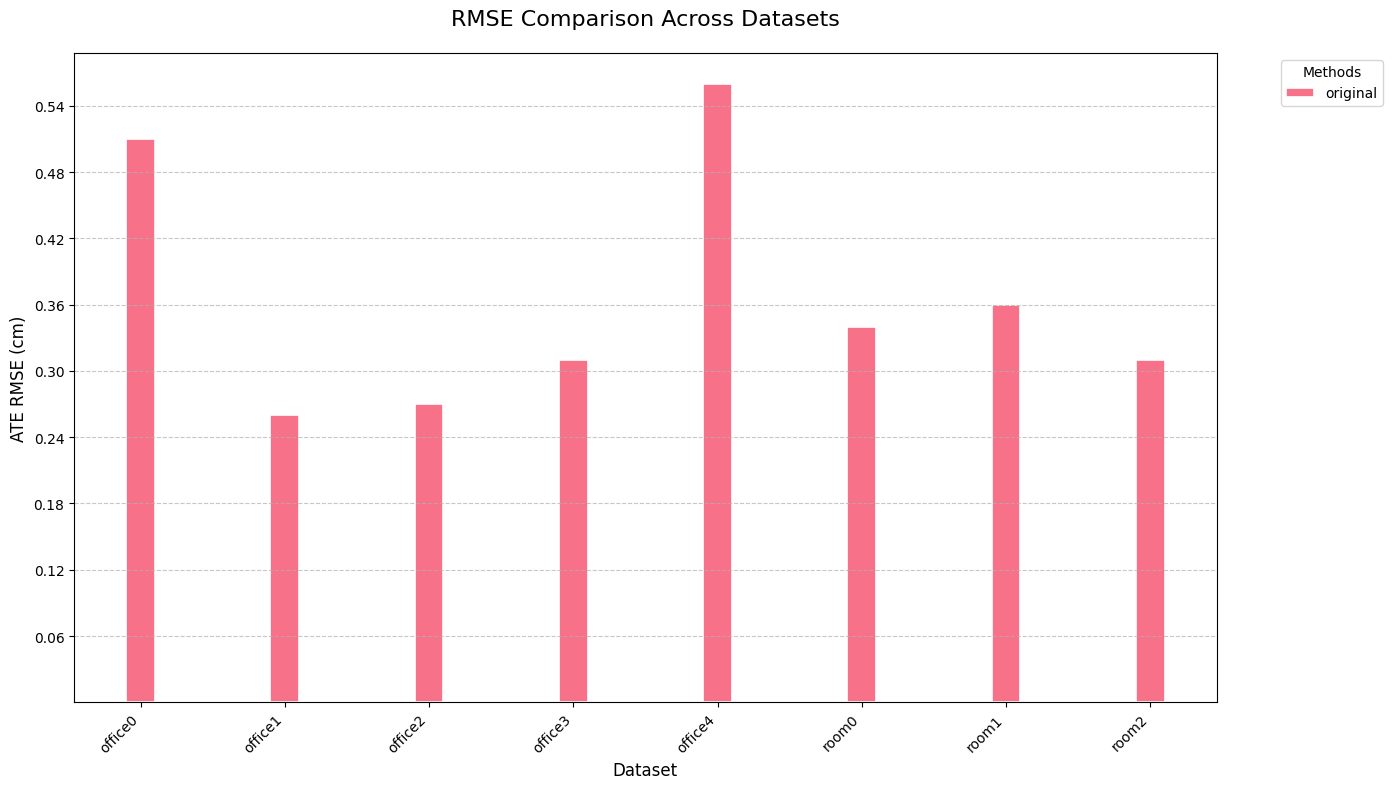

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.read_csv('output.csv')
df = df.set_index(df.columns[0], drop=True)
columns = [col for col in df.columns if 'rmse' in col]

# 设置样式
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("husl")

# 示例数据
datasets = [col.split('_')[0] for col in columns]

methods = ['original']
psnr_data = {
    method: df.loc[method, columns].tolist()
    for method in methods
}

# 创建图形
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)

# 柱状图参数
bar_width = 0.2
x = np.arange(len(datasets))
n_methods = len(methods)

# 绘制柱状图
for i, (method, values) in enumerate(psnr_data.items()):
    offset = (i - n_methods/2) * bar_width + bar_width/2
    bars = ax.bar(x + offset, values, width=bar_width, 
                 label=method, edgecolor='white', linewidth=1.2)
    
    # # 添加数值标签
    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f'{height:.2f}',
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 3),  # 3 points vertical offset
    #                 textcoords="offset points",
    #                 ha='center', va='bottom', fontsize=9)

# 添加标题和标签
ax.set_title('RMSE Comparison Across Datasets', fontsize=16, pad=20)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('ATE RMSE (cm)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)

# 美化坐标轴
ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 添加图例
ax.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局
# plt.ylim(20, 40)
plt.tight_layout()
plt.show()

## 100 frames
original
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 40.56
Average Depth RMSE: 0.19 cm
Average Depth L1: 0.19 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.031
```
---

l1_gradient_s3im loss, dense flip
```bash
Final Average ATE RMSE: 0.14 cm
Average PSNR: 40.30
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.031
```

l1 loss, dense flip
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 39.90
Average Depth RMSE: 0.22 cm
Average Depth L1: 0.22 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.032
```

l1_gradient_s3im loss, dense flip, depth all
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 40.13
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.033
```

tracking uniform 8_8 | mapping l1_gradient_s3im loss, 3-step flip, depth all
```bash
Final Average ATE RMSE: 0.15 cm
Average PSNR: 40.30
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.032
```

tracking uniform 8_8 | mapping l1_gradient_s3im loss, dense flip, depth all
```bash
Final Average ATE RMSE: 0.15 cm
Average PSNR: 40.33
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.033
```

mapping l1_s3im(w original) loss, dense flip, depth all, mapping_scale 4
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 40.33
Average Depth RMSE: 0.19 cm
Average Depth L1: 0.19 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.033
```

mapping l1_s3im(no original) loss, dense flip, depth all, mapping_scale 4
```bash
Final Average ATE RMSE: 0.14 cm
Average PSNR: 40.32
Average Depth RMSE: 0.19 cm
Average Depth L1: 0.19 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.032
```

# frame 100 && map every 4

original
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 40.63
Average Depth RMSE: 0.19 cm
Average Depth L1: 0.19 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.029
```
---

l1_s3im loss, 16x, no dense
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 39.85
Average Depth RMSE: 0.21 cm
Average Depth L1: 0.21 cm
Average MS-SSIM: 0.994
Average LPIPS: 0.040
```
---

l1_s3im loss, 16x, dense interval 2
```bash
Final Average ATE RMSE: 0.15 cm
Average PSNR: 40.42
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.031
```
---

l1_s3im loss, 16x, dense interval: 4 
```bash
Final Average ATE RMSE: 0.14 cm
Average PSNR: 40.24
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.034
```

l1_s3im, 16x, dense interval: 8
```bash
Final Average ATE RMSE: 0.13 cm
Average PSNR: 40.27
Average Depth RMSE: 0.20 cm
Average Depth L1: 0.20 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.035
```

goodFeatures, 64x, 16x, 8-step flip
```bash
Final Average ATE RMSE: 0.14 cm
Average PSNR: 40.23
Average Depth RMSE: 0.22 cm
Average Depth L1: 0.22 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.031
```

harris, 256x, 16x, 8-step
```bash
Final Average ATE RMSE: 0.10 cm
Average PSNR: 40.36
Average Depth RMSE: 0.23 cm
Average Depth L1: 0.23 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.029
```

# Room1 100frames
original
```bash
Final Average ATE RMSE: 0.0778 cm
Average PSNR: 40.06
Average Depth RMSE: 0.15 cm
Average Depth L1: 0.15 cm
Average MS-SSIM: 0.995
Average LPIPS: 0.021
```

random flip 8
```bash
Final Average ATE RMSE: 0.1490 cm
Average PSNR: 39.40
Average Depth RMSE: 0.13 cm
Average Depth L1: 0.13 cm
Average MS-SSIM: 0.994
Average LPIPS: 0.024
```